# Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


# Libraries

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [ ]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [ ]:
# Building our data frame 
df = pd.DataFrame()

for i in range(0, 36):
  temp_df = pd.DataFrame(X_train[:, i, :])
  temp_df["user_id"] = i
  temp_df["label"] = y_train
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"ch_0", 1:"ch_1", 2:"ch_2", 3:"ch_3", 4:"ch_4", 5:"ch_5", })
print(df.shape)
df.head()

(87444, 8)


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
0,17.5970,8.17130,-1.7842,-19.7060,-9.7135,-61.887,0,0
1,2.4209,-0.56039,23.6540,-3.8171,1.3721,8.251,0,0
2,39.6880,701.29000,3003.8000,34.8060,65.0360,77.808,0,0
3,1.6554,-1.94840,14.9890,-4.5047,-1.9535,16.397,0,0
4,-15.1390,5.36330,9.6577,-4.3281,-5.4659,22.605,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87444 entries, 0 to 2428
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ch_0     87444 non-null  float64
 1   ch_1     87444 non-null  float64
 2   ch_2     87444 non-null  float64
 3   ch_3     87444 non-null  float64
 4   ch_4     87444 non-null  float64
 5   ch_5     87444 non-null  float64
 6   user_id  87444 non-null  int64  
 7   label    87444 non-null  int32  
dtypes: float64(6), int32(1), int64(1)
memory usage: 5.7 MB


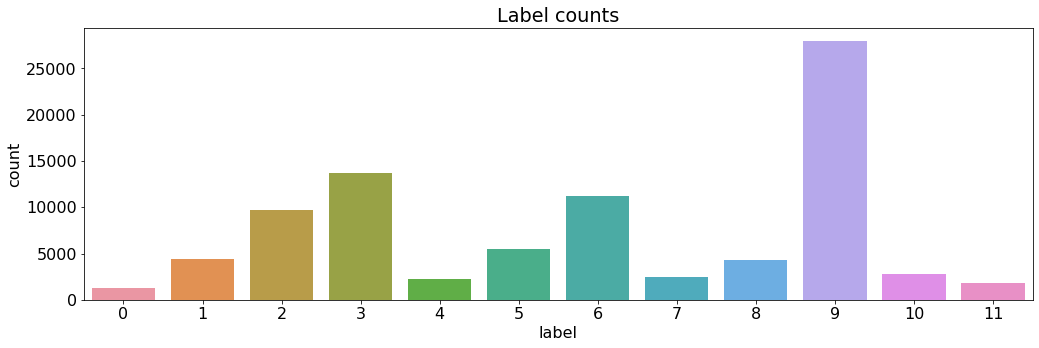

In [ ]:
# Inspect Labels
plt.figure(figsize=(17,5))
sns.countplot(x = 'label', data = df)
plt.title('Label counts')
plt.show()

In [ ]:
def inspect_activity(activity, df):
    data = df[df['label'] == activity][['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']][:500]
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)
    for ax in axis:
        ax.legend(loc='lower right')

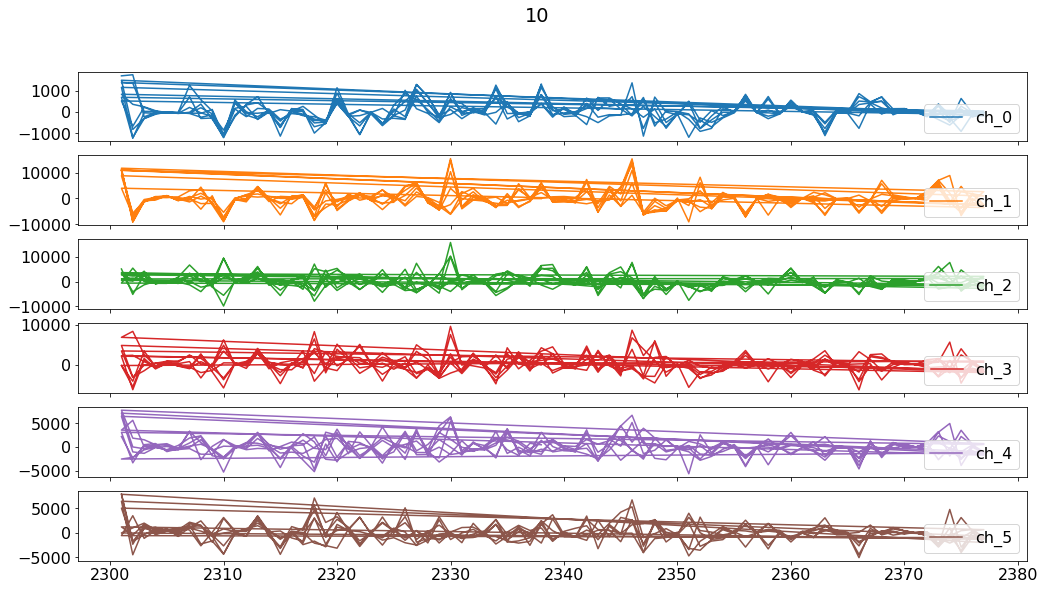

In [ ]:
inspect_activity(10, df)

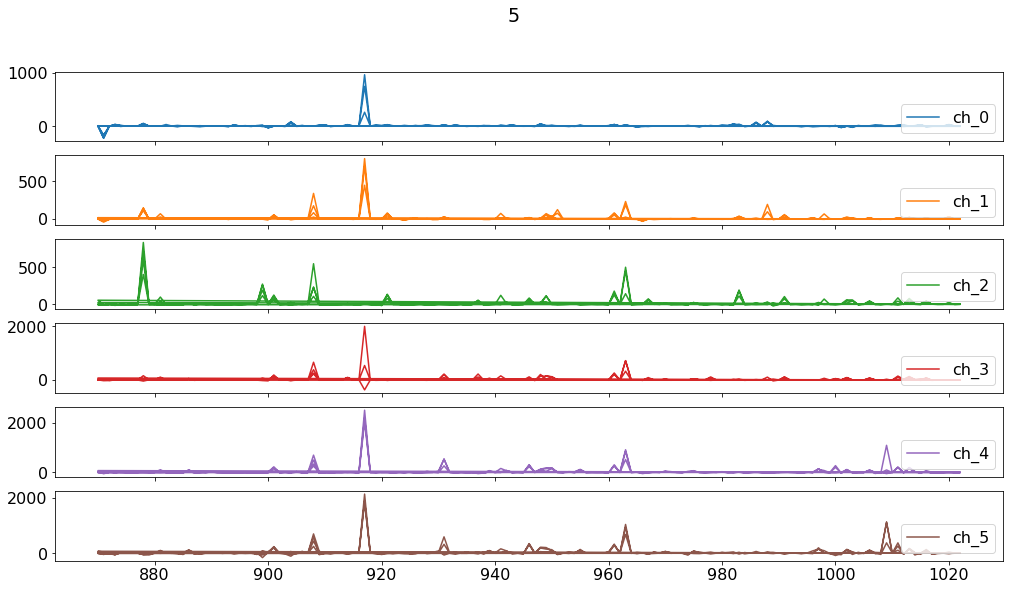

In [ ]:
inspect_activity(5, df)

In [ ]:
# Split over users
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]
df_train.shape, df_test.shape

((75299, 8), (12145, 8))

In [ ]:
# Training users split
training_labels = {
    '0': 0,
    '1': 0,
    '2': 0,
    '3': 0,
    '4': 0,
    '5': 0,
    '6': 0,
    '7': 0,
    '8': 0,
    '9': 0,
    '10': 0,
    '11': 0
}
for l in df_train['label']:
    label = df_train[df_train['label'] == l]['label'].values[0]
    training_labels[str(label)] += 1
print('Training labels:\n',training_labels)

KeyboardInterrupt: ignored

In [ ]:
test_labels = {
    '0': 0,
    '1': 0,
    '2': 0,
    '3': 0,
    '4': 0,
    '5': 0,
    '6': 0,
    '7': 0,
    '8': 0,
    '9': 0,
    '10': 0,
    '11': 0
}
for l in df_test['label']:
    label = df_test[df_test['label'] == l]['label'].values[0]
    test_labels[str(label)] += 1
print('Test labels:\n',test_labels)

Test labels: {'0': 170, '1': 615, '2': 1350, '3': 1905, '4': 310, '5': 765, '6': 1565, '7': 340, '8': 600, '9': 3885, '10': 385, '11': 255}


In [ ]:
# Apply MinMaxScaler to the useful features
scale_columns = ['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']
scaler = StandardScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
df_train.head()

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
0,0.044896,-0.012622,-0.040297,-0.077740,-0.065341,-0.129617,0,0
1,-0.033171,-0.023990,-0.002825,-0.053396,-0.047489,-0.029687,0,0
2,0.158534,0.889793,4.387045,0.005779,0.055035,0.069415,0,0
3,-0.037108,-0.025798,-0.015589,-0.054450,-0.052844,-0.018081,0,0
4,-0.123500,-0.016278,-0.023442,-0.054179,-0.058501,-0.009236,0,0


In [ ]:
df_test.head()

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
0,0.431165,0.557220,0.258059,-0.265493,0.596068,-0.128239,31,0
1,-0.116319,-0.026826,-0.036591,-0.051510,-0.036322,-0.043903,31,0
2,0.081486,-0.007230,-0.044215,-0.058914,-0.015011,-0.114555,31,0
3,-0.029480,-0.024907,-0.049892,-0.052665,-0.041341,0.042005,31,0
4,-0.095886,0.104205,0.122937,0.696743,-0.075273,-0.624011,31,0


In [ ]:
window = 36
stride = 9

In [ ]:
def build_sequences(df, window=36, stride=6):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for l in df['label'].unique():
        # Take only meaningful features
        temp = df[df['label'] == l][['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']].values
        # Save the label
        label = df[df['label'] == l]['label'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(df_train, window, stride)
X_test, y_test = build_sequences(df_test, window, stride)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8356, 36, 6), (8356,), (1336, 36, 6), (1336,))

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8356, 36, 6), (8356, 12), (1336, 36, 6), (1336, 12))

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [ ]:
# Train the model
history = model.fit(
    x = X_train[:,:,:],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
59/59 [==============================] - 23s 319ms/step - loss: 1.9439 - accuracy: 0.3322 - val_loss: 3.4125 - val_accuracy: 0.4390 - lr: 0.0010
Epoch 2/200
59/59 [==============================] - 15s 255ms/step - loss: 1.3434 - accuracy: 0.5106 - val_loss: 4.2042 - val_accuracy: 0.3230 - lr: 0.0010
Epoch 3/200
59/59 [==============================] - 15s 251ms/step - loss: 1.1361 - accuracy: 0.5918 - val_loss: 5.2281 - val_accuracy: 0.3541 - lr: 0.0010
Epoch 4/200
59/59 [==============================] - 15s 263ms/step - loss: 1.0526 - accuracy: 0.6253 - val_loss: 5.1776 - val_accuracy: 0.3864 - lr: 0.0010
Epoch 5/200
59/59 [==============================] - 16s 271ms/step - loss: 0.9484 - accuracy: 0.6656 - val_loss: 5.7195 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 6/200
59/59 [==============================] - 15s 248ms/step - loss: 0.8941 - accuracy: 0.6863 - val_loss: 6.2393 - val_accuracy: 0.4222 - lr: 0.0010
Epoch 7/200
59/59 [==============================] - 16s 2

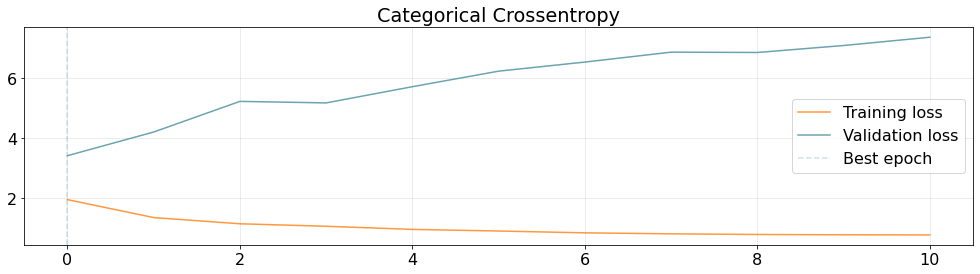

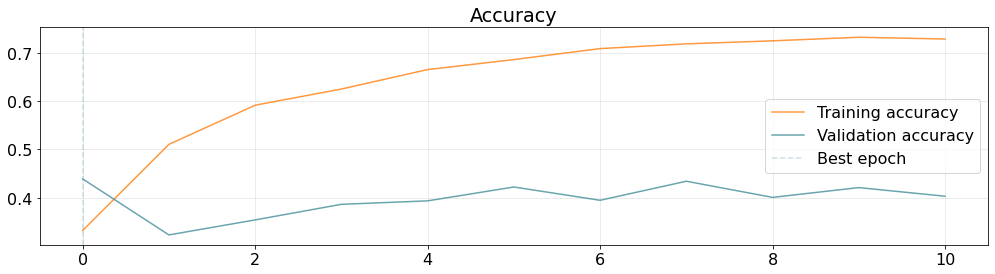

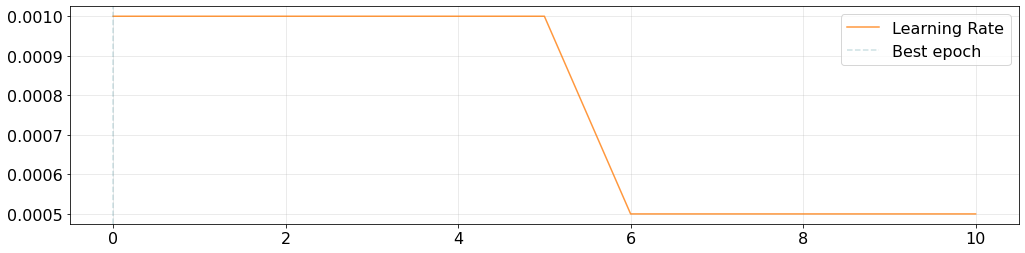

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM')
# model = tfk.models.load_model('LSTM')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

42/42 [==============================] - 3s 42ms/step


(1336, 12)

Accuracy: 0.4671
Precision: 0.2268
Recall: 0.2926
F1: 0.2155


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


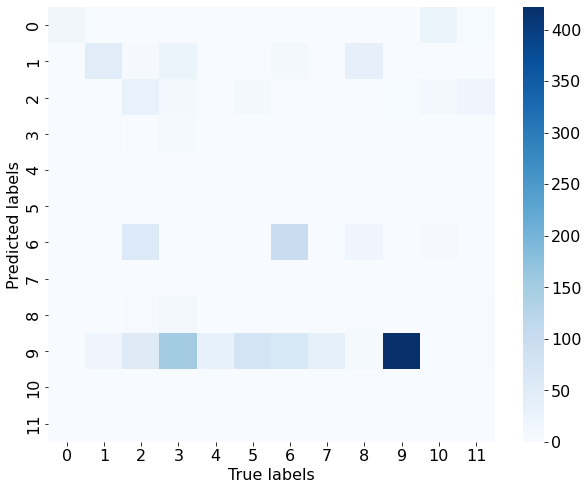

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
59/59 [==============================] - 45s 633ms/step - loss: 1.7257 - accuracy: 0.4045 - val_loss: 3.6916 - val_accuracy: 0.3660 - lr: 0.0010
Epoch 2/200
59/59 [==============================] - 34s 580ms/step - loss: 1.1526 - accuracy: 0.5813 - val_loss: 4.3898 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 3/200
59/59 [==============================] - 32s 550ms/step - loss: 0.9717 - accuracy: 0.6489 - val_loss: 5.4366 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 4/200
59/59 [==============================] - 32s 534ms/step - loss: 0.9069 - accuracy: 0.6794 - val_loss: 5.5522 - val_accuracy: 0.4031 - lr: 0.0010
Epoch 5/200
59/59 [==============================] - 34s 569ms/step - loss: 0.8356 - accuracy: 0.7108 - val_loss: 6.0096 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 6/200
59/59 [==============================] - 31s 532ms/step - loss: 0.8316 - accuracy: 0.7065 - val_loss: 6.6065 - val_accuracy: 0.4199 - lr: 0.0010
Epoch 7/200
59/59 [==============================] - 31s 5

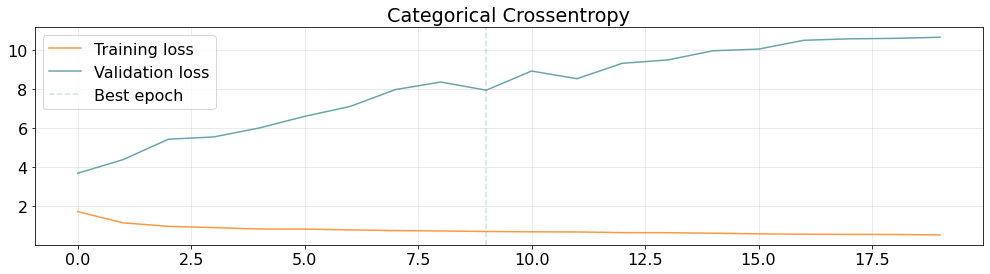

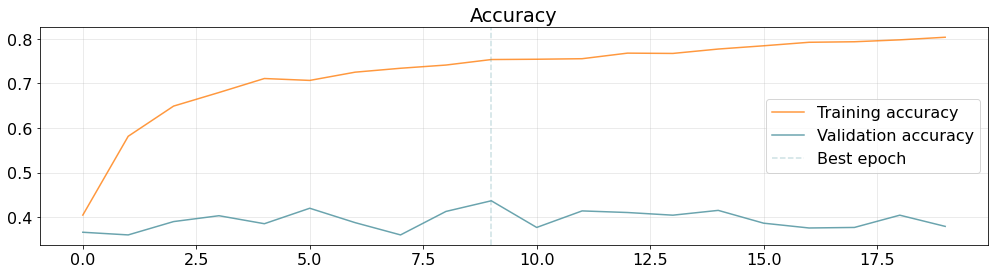

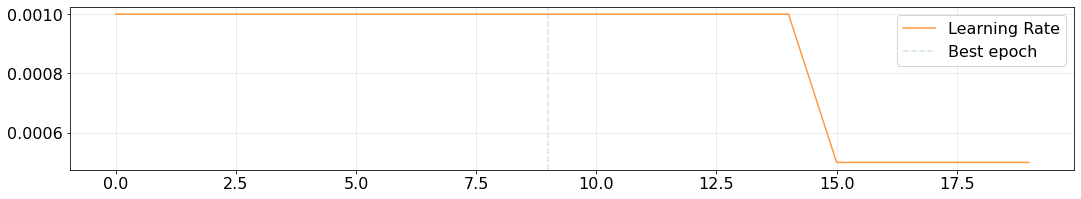

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('BiLSTM')
# model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

42/42 [==============================] - 6s 117ms/step


(1336, 12)

Accuracy: 0.7118
Precision: 0.5087
Recall: 0.5282
F1: 0.5104


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


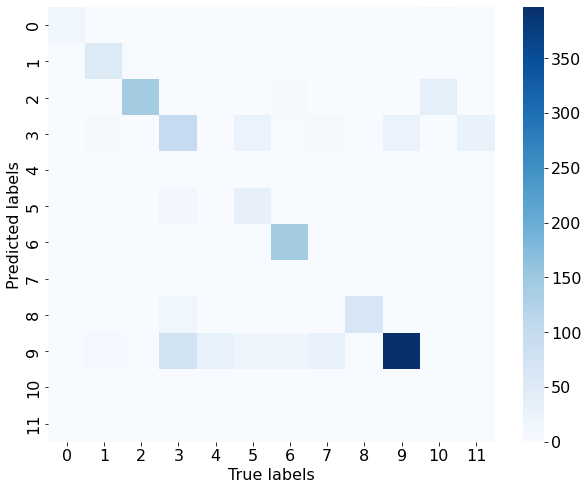

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
59/59 [==============================] - 3s 37ms/step - loss: 1.9758 - accuracy: 0.3491 - val_loss: 23.5394 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 2/200
59/59 [==============================] - 2s 35ms/step - loss: 1.2449 - accuracy: 0.5890 - val_loss: 47.0979 - val_accuracy: 0.4414 - lr: 0.0010
Epoch 3/200
59/59 [==============================] - 2s 34ms/step - loss: 1.0219 - accuracy: 0.6459 - val_loss: 61.3093 - val_accuracy: 0.3744 - lr: 0.0010
Epoch 4/200
59/59 [==============================] - 3s 55ms/step - loss: 0.9277 - accuracy: 0.6795 - val_loss: 67.2415 - val_accuracy: 0.4366 - lr: 0.0010
Epoch 5/200
59/59 [==============================] - 2s 42ms/step - loss: 0.8720 - accuracy: 0.6957 - val_loss: 76.7510 - val_accuracy: 0.3481 - lr: 0.0010
Epoch 6/200
59/59 [==============================] - 2s 34ms/step - loss: 0.8229 - accuracy: 0.7100 - val_loss: 76.7870 - val_accuracy: 0.4426 - lr: 0.0010
Epoch 7/200
59/59 [==============================] - 2s 34ms/ste

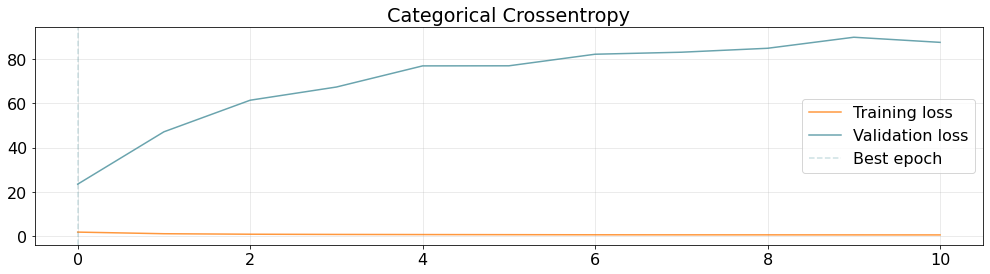

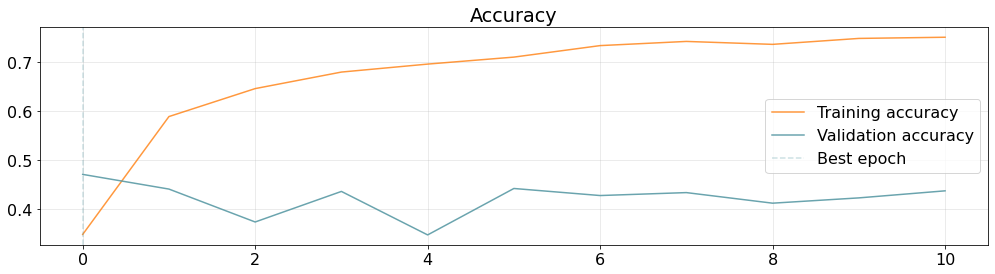

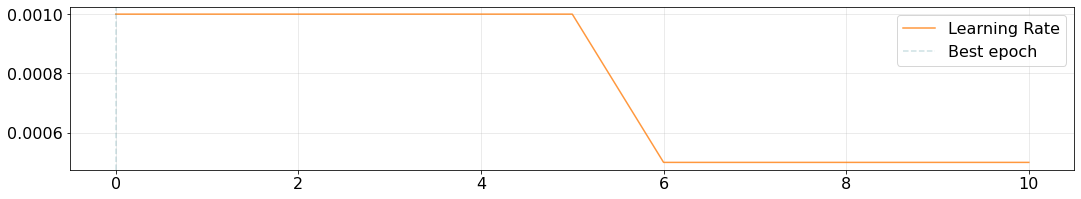

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('1DCNN')
# model = tfk.models.load_model('1DCNN')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

42/42 [==============================] - 0s 5ms/step


(1336, 12)

Accuracy: 0.5472
Precision: 0.3917
Recall: 0.3732
F1: 0.3511


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


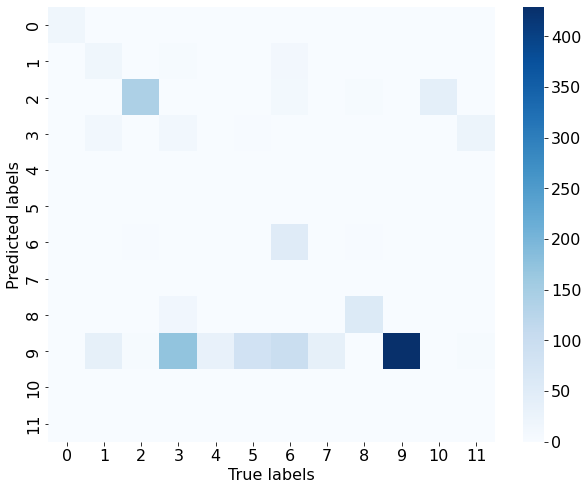

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()